<a href="https://colab.research.google.com/github/IAMPathak2702/Malaria-Cell-Image-Detection/blob/main/Malaria_cell_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset from kaggle


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras import layers,Sequential,preprocessing
from keras.layers import Flatten , Dense , Conv2D , MaxPool2D

import os
import random
import pathlib

In [9]:
!chmod 600 /content/kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [10]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 658M/675M [00:04<00:00, 171MB/s]
100% 675M/675M [00:04<00:00, 149MB/s]


In [11]:
!unzip -q \*.zip

In [12]:
for dirpath, dirnames, filenames in os.walk("/content/cell_images"):

  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/cell_images'.
There are 0 directories and 13780 images in '/content/cell_images/Uninfected'.
There are 0 directories and 13780 images in '/content/cell_images/Parasitized'.
There are 2 directories and 0 images in '/content/cell_images/cell_images'.
There are 0 directories and 13780 images in '/content/cell_images/cell_images/Uninfected'.
There are 0 directories and 13780 images in '/content/cell_images/cell_images/Parasitized'.


# defining path and Visualising dataset

In [15]:
train_dir = "/content/cell_images/cell_images/"

## Splitting the Dataset into Train and Validation Sets and Converting It into a tf.data.Dataset

In [16]:
train_data = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,
    validation_split=0.2,
    subset="training",

)

val_data = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,
    validation_split=0.2,
    subset="validation",

)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


## Extracting Class Names

In [17]:
_class_names = train_data.class_names
_class_names

['Parasitized', 'Uninfected']

## Defining Visualisation Function

In [18]:
def view_random_image(target_dir,class_names):
    # Setup target directory (we'll view images from here)

    plt.figure(figsize = (20,14))
    for i in range(0,12):
        target_class = random.choice(list(class_names))
        target_folder = target_dir+target_class
        # Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        # Read in the image and plot it using matplotlib

        img = mpimg.imread(target_folder + "/" + random_image[0])
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(f"{target_class}--{img.shape}")
        plt.axis("off");
    return img


## Visualise the dataset

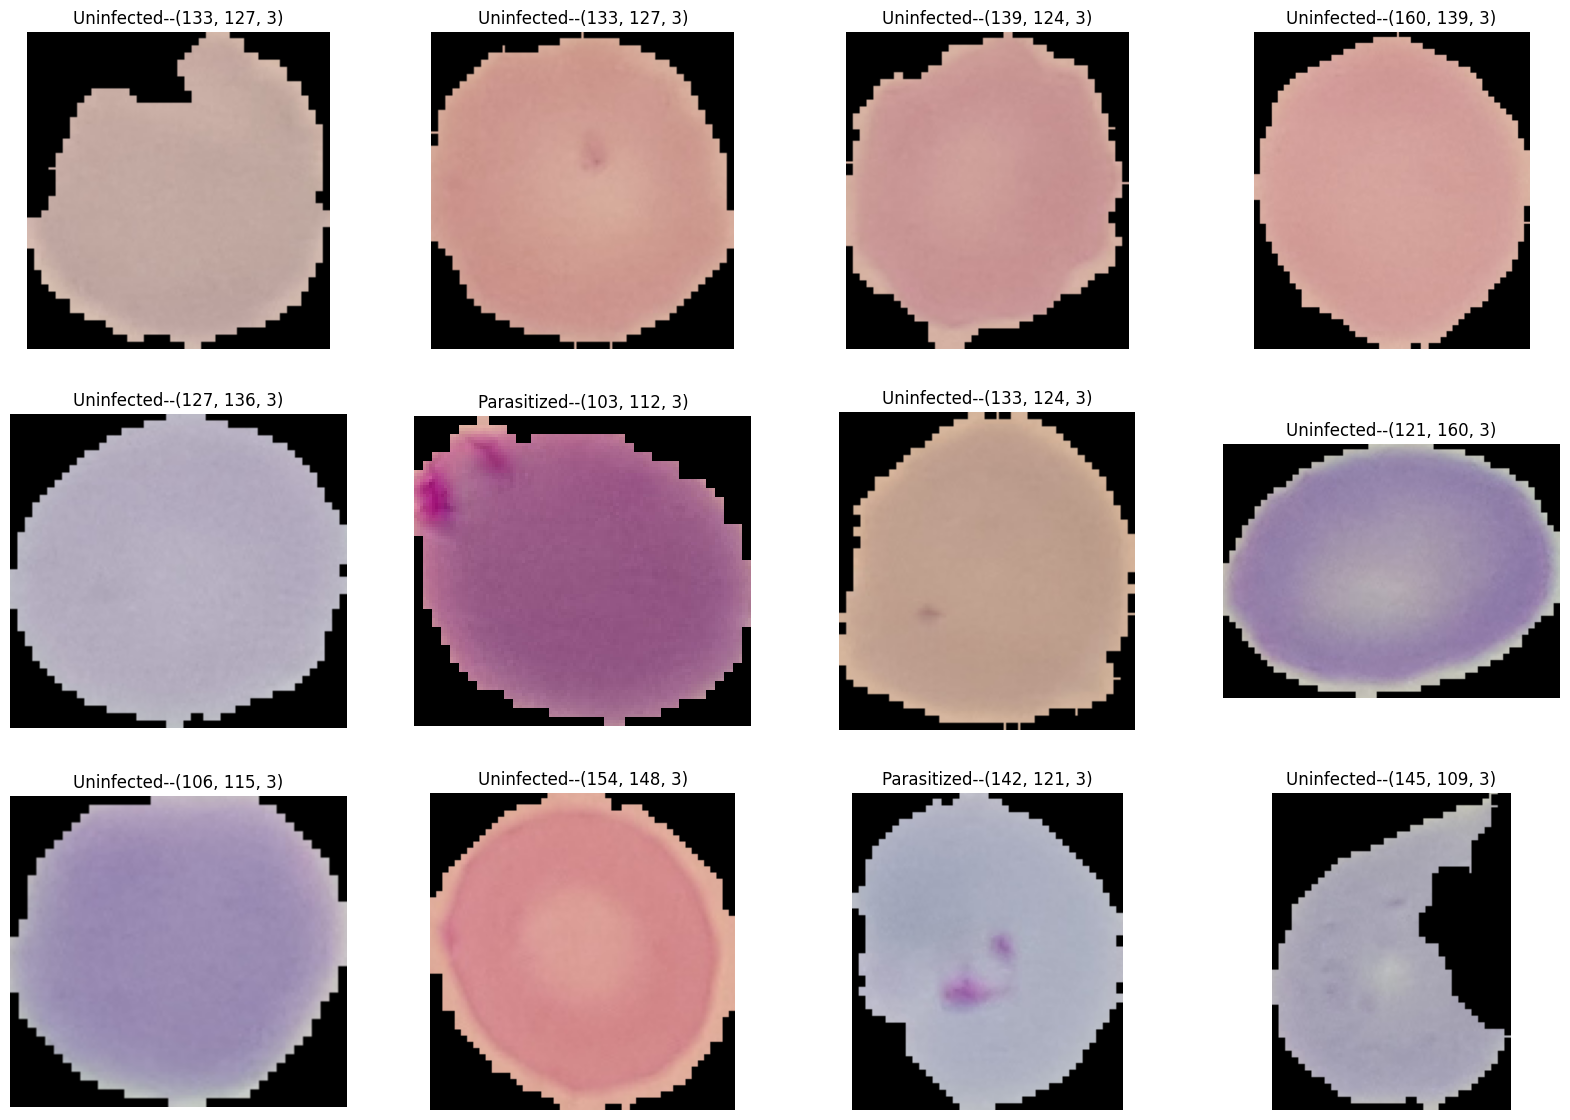

In [19]:
img = view_random_image(target_dir=train_dir,
                        class_names = _class_names)

# Prefetching data , Defining Callback functions , Early stopping and Data Augumentation layer

In [20]:
train_ds = train_data.prefetch(tf.data.AUTOTUNE)
val_ds = val_data.prefetch(tf.data.AUTOTUNE)

In [21]:
def model_checkpoint_callback(filepath):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/content/{filepath}',  # Specify the path to save the best model
        monitor='val_accuracy',   # Choose a metric to monitor (e.g., validation accuracy)
        save_best_only=True,       # Save only the best model
        save_weights_only=False,   # Set to True if you want to save only model weights
        mode='max',               # Set to 'max' for accuracy, 'min' for loss, or 'auto'
        verbose=0,               # Optional: Set to 1 for progress messages
    )
    return model_checkpoint_callback

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
                                                monitor='val_loss',   # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
                                                patience=3,           # Number of epochs with no improvement before stopping
                                                restore_best_weights=True  # Restore model weights from the best epoch
                                            )

In [23]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),  # Rescale pixel values
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # Randomly rotate images up to 20 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),  # Randomly zoom images up to 20%
],name = "Data_Augumentation_layer")

# Defining our ResNet50 Model via Functional API

In [24]:
from keras.applications import ResNet50

resnet = ResNet50(input_shape = (224,224,3) , include_top = False)
for layer in resnet.layers:
    layer.trainable = False



94765736/94765736 [==============================] - 3s 0us/step


In [28]:
x=data_augmentation_layer(resnet.output)
x = Flatten()(x)
o = Dense(len(_class_names), activation="softmax", name="output_layer")(x)

model_1 = keras.Model(resnet.input ,o, name = "RESNET_MODEL")
model_1.summary()

Model: "RESNET_MODEL"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                   

## compilng the model

In [29]:
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

## Fitting the model with train_ds and Val_ds

In [30]:
hist_1 = model_1.fit(train_ds,
                        epochs = 3,
                        validation_data = val_ds,
                        callbacks = [model_checkpoint_callback('MOdel_RESNET50'),early_stopping])

Epoch 1/3
689/689 [==============================] - 164s 232ms/step - loss: 0.2859 - accuracy: 0.8885 - val_loss: 0.2132 - val_accuracy: 0.9194
Epoch 2/3
689/689 [==============================] - 158s 228ms/step - loss: 0.2097 - accuracy: 0.9208 - val_loss: 0.1851 - val_accuracy: 0.9310
Epoch 3/3
689/689 [==============================] - 160s 232ms/step - loss: 0.1890 - accuracy: 0.9285 - val_loss: 0.1753 - val_accuracy: 0.9378


# Evaluating History of the model!!

In [31]:
def plot_hist_graph(history):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title("Epoch vs Accuracy")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplot(1, 3, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

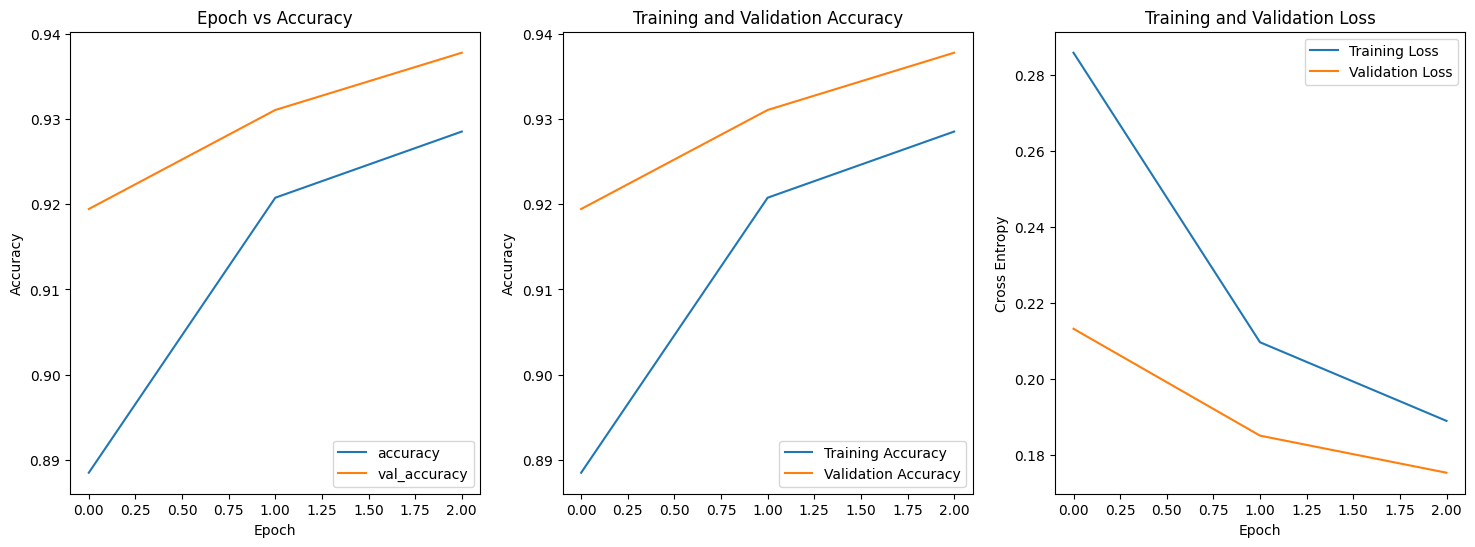

In [32]:
plot_hist_graph(hist_1)